In [5]:
import os
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import gensim.downloader

from dataset import SAYCamEvalDataset, WordDictionary
from train import ImageUtteranceModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# load pretrained model
model = torchvision.models.resnext50_32x4d(pretrained=False)
model.fc = torch.nn.Linear(in_features=2048, out_features=2765, bias=True)

# load in checkpoint
checkpoint = torch.load('models/resnext50_32x4d_augmentation_True_S_5_288.tar')

# rename checkpoint keys since we are not using DataParallel
prefix = 'module.'
n_clip = len(prefix)
renamed_checkpoint = {k[n_clip:]: v for k, v in checkpoint['model_state_dict'].items()}

# load state dict 
model.load_state_dict(renamed_checkpoint)
model = model.to(device)

# get evaluation categories
categories = sorted(os.listdir('/misc/vlgscratch4/LakeGroup/shared_data/S_clean_labeled_data_1fps_5'))

# set transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# create ImageFolder
image_dir = '/misc/vlgscratch4/LakeGroup/shared_data/S_clean_labeled_data_1fps_5'
dataset = ImageFolder(root=image_dir, transform=transforms.Compose([transforms.ToTensor(), normalize]))
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=8)

In [7]:
image_embeddings = []
label_embeddings = []

with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        embeddings = model(images)
        image_embeddings.append(embeddings.detach().cpu().numpy())
        label_embeddings.append(labels.detach().cpu().numpy())
        
image_embeddings_arr = np.concatenate(image_embeddings)
label_embeddings_arr = np.concatenate(label_embeddings)
np.save('viz/eval_image_embeddings.npy', image_embeddings_arr)
np.save('viz/eval_labels.npy', label_embeddings_arr)

In [4]:
import os
import sklearn.datasets
import pandas as pd
import numpy as np
import umap
import umap.plot

In [10]:
image_embeddings_arr = np.load('viz/eval_image_embeddings.npy')
label_embeddings_arr = np.load('viz/eval_labels.npy')
categories = sorted(os.listdir('/misc/vlgscratch4/LakeGroup/shared_data/S_clean_labeled_data_1fps_5'))
category_labels = np.array([categories[i] for i in label_embeddings_arr])
mapper = umap.UMAP(n_neighbors=10, min_dist=0.0).fit(image_embeddings_arr)

<AxesSubplot:>

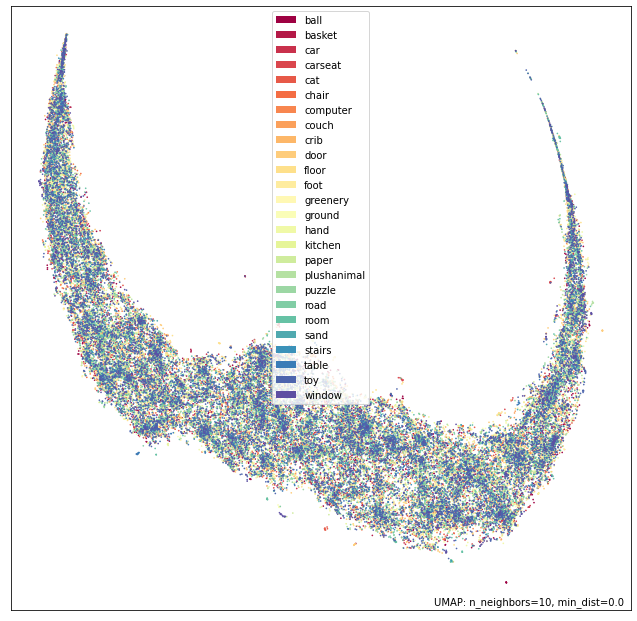

In [59]:
umap.plot.points(mapper, labels=category_labels)

In [53]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(image_embeddings_arr)
image_embeddings_pca = pca.transform(image_embeddings_arr)

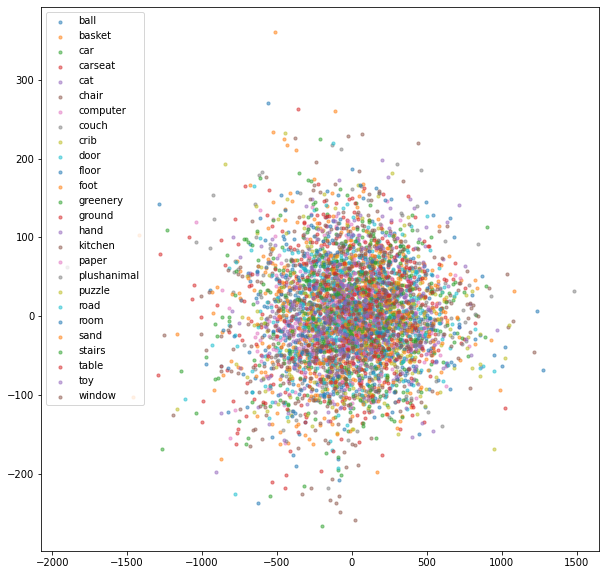

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

embeddings_df = pd.DataFrame({'x1': image_embeddings_pca[:, 0], 
                              'x2': image_embeddings_pca[:, 1],
                              'y': label_embeddings_arr})

groups = embeddings_df.groupby('y')
fig = plt.figure(figsize=(10, 10))
for idx, (name, group) in enumerate(groups):
    plt.scatter(group['x1'][:200], group['x2'][:200], marker="o", label=categories[idx], alpha=0.5, s=10)
plt.legend()
plt.show()

# plt.scatter(image_embeddings_pca[:, 0], image_embeddings_pca[:, 1])

In [39]:
print(np.min(image_embeddings_pca[:, 0]))
print(np.max(image_embeddings_pca[:, 0]))
print(np.min(image_embeddings_pca[:, 1]))
print(np.max(image_embeddings_pca[:, 1]))

-1902.4005
1949.758
-380.67484
388.91302
